# Statistics and Optimization: Time Series Analysis

In [56]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [57]:
# Set the seed to student number for reproducibility
np.random.seed(23373385)

In [58]:
# Read the dataset
data = pd.read_csv('ts5.csv')

In [59]:
# Get dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  401 non-null    int64  
 1   x           401 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


In [60]:
# Display first few rows of dataset
data.head()

,Unnamed: 0,x
0,1,371.333344
1,2,402.863342
2,3,390.666656
3,4,404.619995
4,5,409.970001


In [61]:
# Create and index date range using daily frequency
data['Time'] = pd.to_datetime(data.index, unit='D', origin='2020-01-01')
data.set_index('Time', inplace=True)
data.index = pd.date_range(start=data.index[0], periods=len(data), freq='D')

In [62]:
# Check and verify updated dataset
data.head()

,Unnamed: 0,x
2020-01-01,1,371.333344
2020-01-02,2,402.863342
2020-01-03,3,390.666656
2020-01-04,4,404.619995
2020-01-05,5,409.970001


In [63]:
# Set required data column with time series to variable
ts_data = data['x']

In [64]:
# Set the style for the plots
sns.set_style('whitegrid')

# Create a color palette with shades of green
blue_palette = sns.color_palette('Blues', 6)

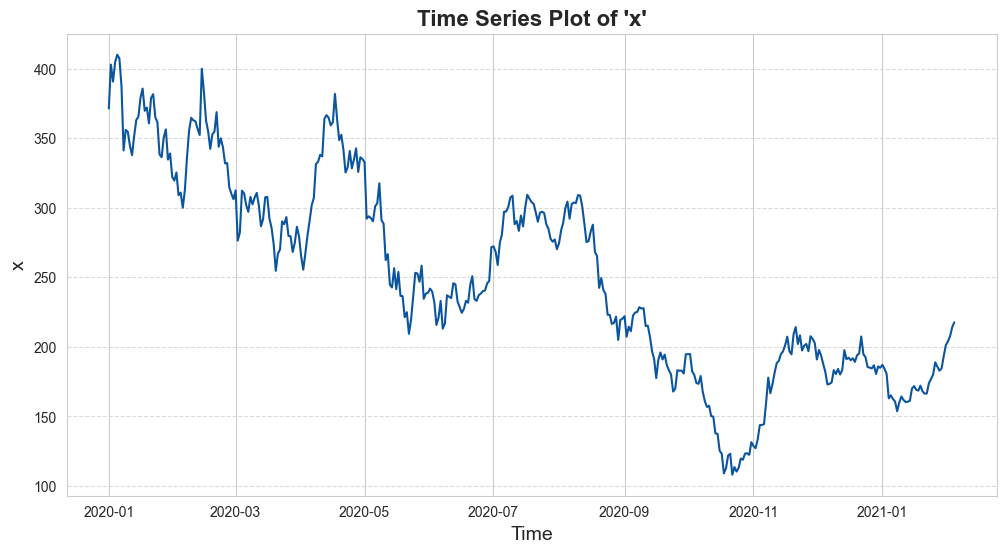

In [65]:
# Time Series Plot for 'x'
plt.figure(figsize=(12, 6))

plt.plot(ts_data, color=blue_palette[5])
plt.title("Time Series Plot of 'x'", fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('x', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Gridlines for y-axis
plt.show()

ADF: (-1.7007758203159313, 0.43071279529604567, 10, 390, {'1%': -3.4472291365835566, '5%': -2.8689795375849223, '10%': -2.5707330834976987}, 2860.287008779748)

ADF Statistic: -1.7007758203159313
p-value: 0.43071279529604567
Critical Values:
1%: -3.4472291365835566
5%: -2.8689795375849223
10%: -2.5707330834976987
 
The time series is not stationary. Differencing required.


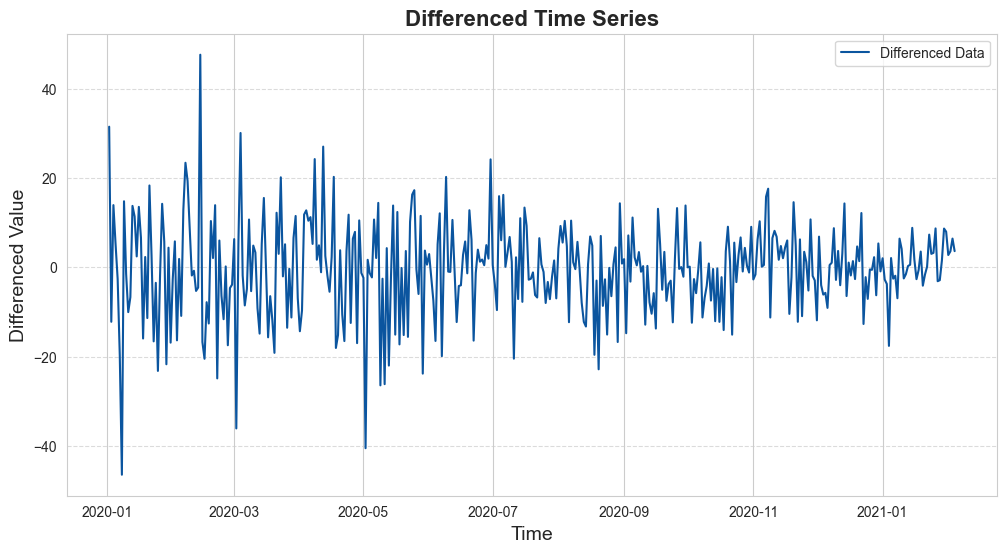


ADF Reapplied:

ADF Statistic: -6.144829495745668
p-value: 7.812768928563175e-08
Critical Values:
1%: -3.4472291365835566
5%: -2.8689795375849223
10%: -2.5707330834976987


In [66]:
# Perform the Augmented Dickey-Fuller (ADF) test for stationarity
adf_result = adfuller(ts_data)

print(f'ADF: {adf_result}\n')

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'{key}: {value}')
print(' ')

if adf_result[1] < 0.05: # A p-value < 0.05 suggests that the time series is stationary.
    print('The time series is stationary.')
else:
    print('The time series is not stationary. Differencing required.')

if adf_result[1] >= 0.05: # If not stationary
    data_diff = data['x'].diff().dropna()
    
    # Plot the differenced time series
    plt.figure(figsize=(12, 6))
    plt.plot(data_diff, color=blue_palette[5], label='Differenced Data')
    plt.title('Differenced Time Series', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Differenced Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
    print('\nADF Reapplied:\n')
    adf_diff_result = adfuller(data_diff)
    print('ADF Statistic:', adf_diff_result[0])
    print('p-value:', adf_diff_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'{key}: {value}')
else:
    data_diff = data['x']

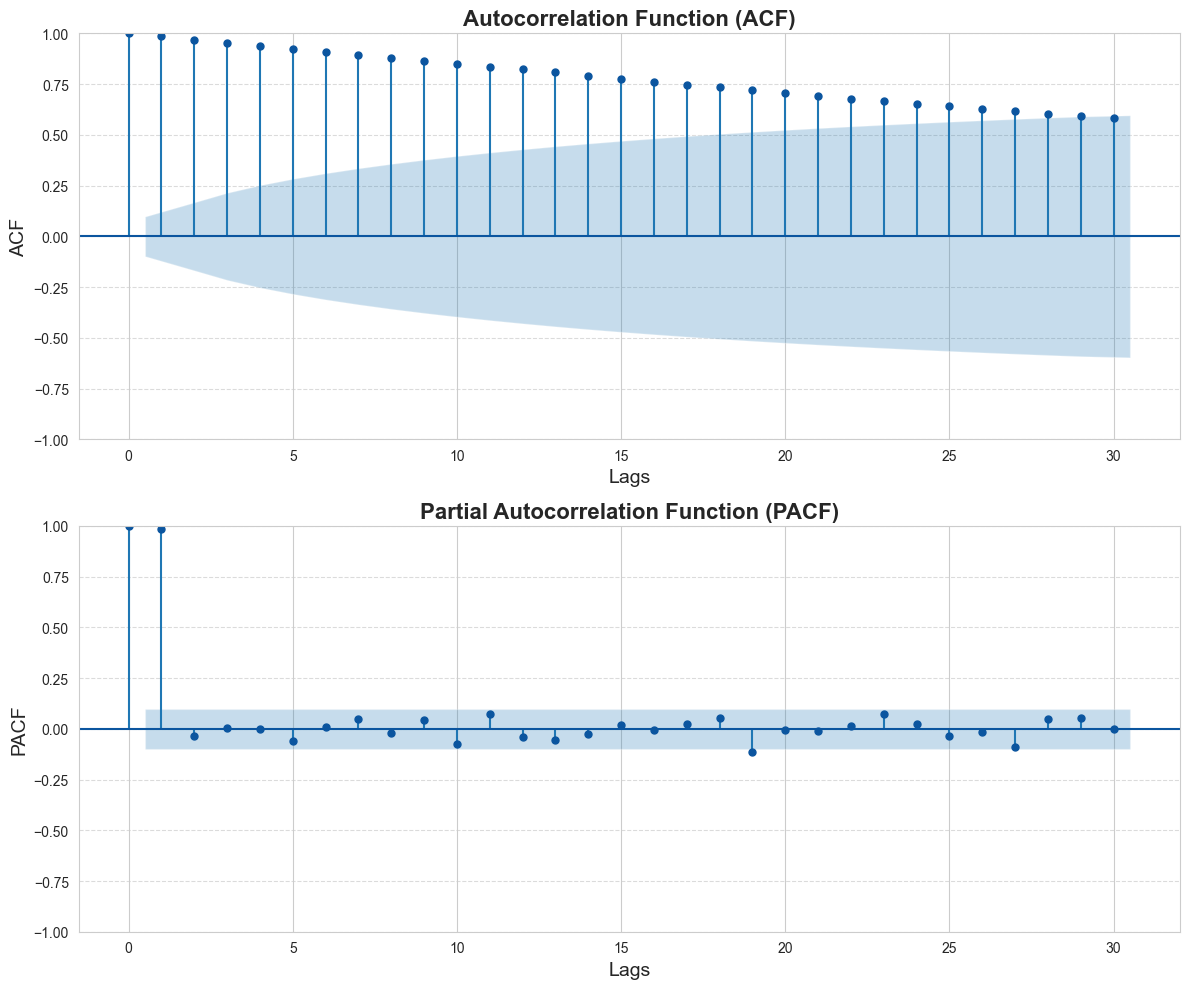

In [67]:
# Create subplots for ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(ts_data, ax=ax[0], lags=30, color=blue_palette[5])
ax[0].set_title('Autocorrelation Function (ACF)', fontsize=16, fontweight='bold')
ax[0].set_xlabel('Lags', fontsize=14)
ax[0].set_ylabel('ACF', fontsize=14)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

plot_pacf(ts_data, ax=ax[1], lags=30, color=blue_palette[5])
ax[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=16, fontweight='bold')
ax[1].set_xlabel('Lags', fontsize=14)
ax[1].set_ylabel('PACF', fontsize=14)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [68]:
# Split the data into a 80% - 20% split into test and train respectively
train_size = int(len(ts_data) * 0.8)
train, test = ts_data.loc['20200101':'20201231'], ts_data.loc['20201231':'20210204']

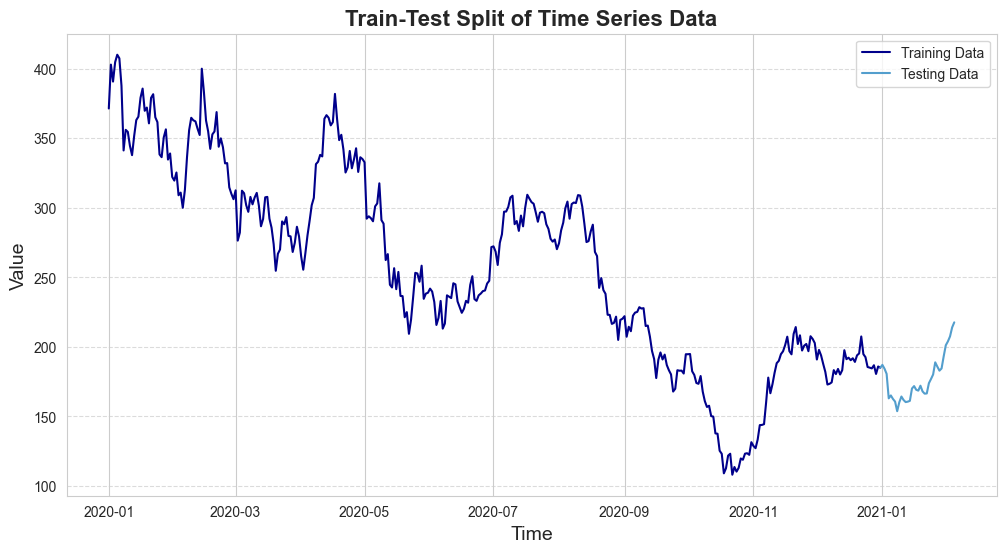

In [69]:
# Plot the training and testing data
plt.figure(figsize=(12, 6))

plt.plot(train, label='Training Data', color='darkblue') 
plt.plot(test, label='Testing Data', color=blue_palette[3])
plt.title('Train-Test Split of Time Series Data', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [70]:
# Set function to collect required error metrics

def evaluate_model(test, forecast, model_name):
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    print(f'{model_name} Performance:')
    print(f' - MAE: {mae:.2f}')
    print(f' - MSE: {mse:.2f}')
    print(f' - RMSE: {rmse:.2f}')
    return rmse, mae

## Auto ARIMA Model

In [71]:
# Perform Auto ARIMA to obtain ideal values of p, d, q
print('\n--- Auto ARIMA Model ---')
model_auto_arima = auto_arima(train, 
                              seasonal=True, 
                              m=12, 
                              trace=True, 
                              error_action='ignore', 
                              suppress_warnings=True, 
                              stepwise=True)


--- Auto ARIMA Model ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2781.539, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2787.681, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2790.231, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2790.294, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2786.472, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2795.734, Time=1.32 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2795.677, Time=1.64 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2796.027, Time=1.78 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=2795.262, Time=1.21 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2794.009, Time=0.55 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2793.651, Time=2.43 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2794.083, Time=2.86 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=3.24 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=2794.539, Time=1.01 se

## ARIMA Model

In [72]:
model_auto_arima.order

(2, 1, 2)

In [73]:
# Fit an ARIMA model using auto_arima
p, d, q = model_auto_arima.order
model_arima = ARIMA(train, order=(p, d, q))
model_fit_arima = model_arima.fit()

C:\Users\ibrah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [74]:
# Get the model summary
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      x   No. Observations:                  366
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1383.317
Date:                Fri, 29 Nov 2024   AIC                           2776.633
Time:                        21:59:06   BIC                           2796.133
Sample:                    01-01-2020   HQIC                          2784.383
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9204      0.006   -297.050      0.000      -1.933      -1.908
ar.L2         -0.9945      0.006   -159.128      0.000      -1.007      -0.982
ma.L1          1.9229      0.025     76.848      0.000       1.874       1.972
ma.L2          0.9897      0.025     39.184      0.000       0.940       1.039
sigma2       113.8134      6.274     18.141      0.000     101.517     126.110
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                76.62
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

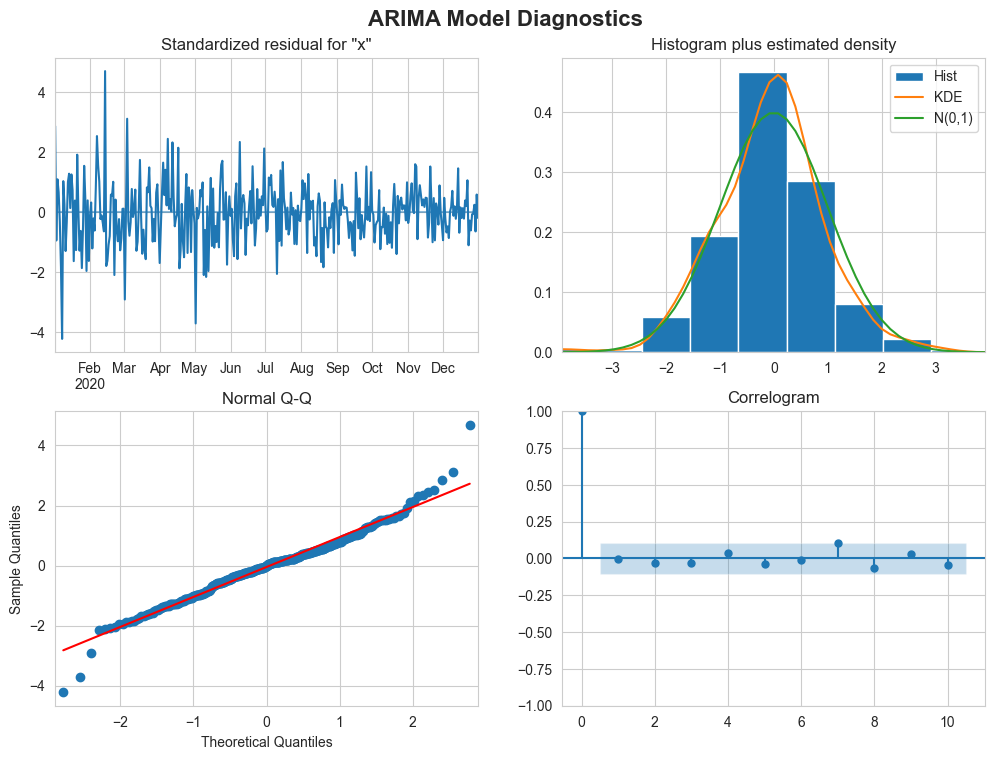

In [75]:
# Plot ARIMA model diagnostics
model_fit_arima.plot_diagnostics(figsize=(12, 8))

plt.suptitle('ARIMA Model Diagnostics', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.92)

plt.show()

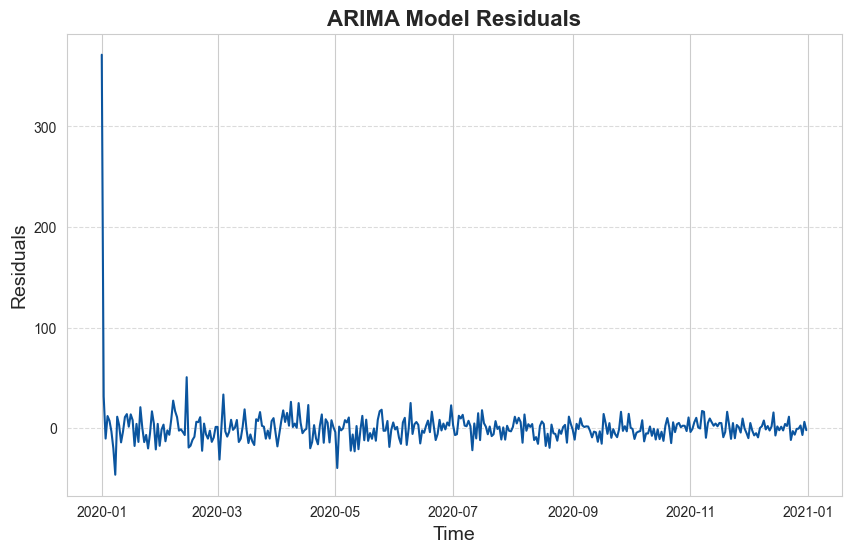

In [76]:
# Extract residuals
arima_residuals = model_fit_arima.resid

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(arima_residuals, color=blue_palette[5])
plt.title('ARIMA Model Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [77]:
# Get the summarty junbox statistics
acorr_ljungbox(model_fit_arima.resid,lags=10)

,lb_stat,lb_pvalue
1,1.553813,0.212573
2,1.841491,0.398222
3,1.971598,0.578323
4,2.205510,0.698021
5,2.272301,0.810326
6,2.953241,0.814692
7,4.833991,0.680214
8,4.867885,0.771599
9,4.936154,0.839838
10,5.502355,0.855199


In [78]:
# Forecast the values
forecast_arima = model_fit_arima.forecast(steps=len(test))

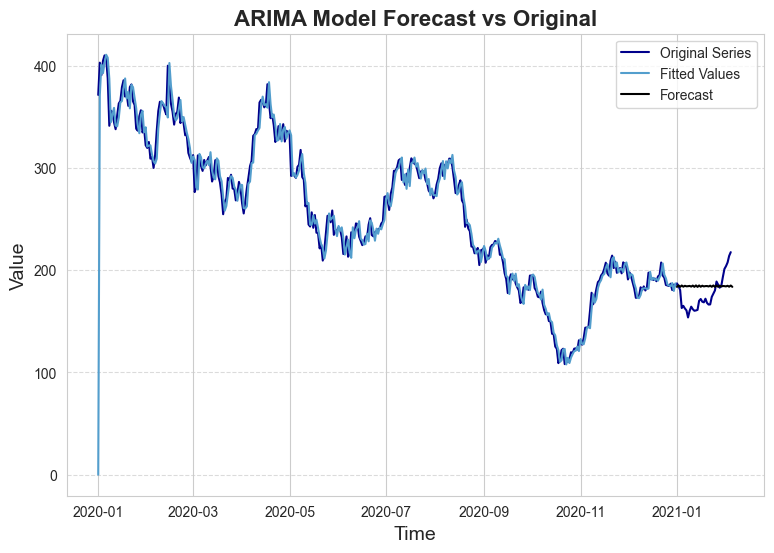

In [79]:
# Plot forecast values
plt.figure(figsize=(9,6))
plt.plot(ts_data, color='darkblue', label='Original Series')
plt.plot(model_fit_arima.fittedvalues, color=blue_palette[3], label='Fitted Values')
plt.plot(forecast_arima, color='black', label='Forecast')
plt.title('ARIMA Model Forecast vs Original', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)

plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [80]:
# Evaluate ARIMA
evaluate_model(test, forecast_arima, 'ARIMA')

ARIMA Performance:
 - MAE: 15.18
 - MSE: 316.69
 - RMSE: 17.80


(17.79592473866103, 15.176071911695313)

In [81]:
# Check P-values of coefficients for significance
print('\nARIMA Model Coefficients with P-values:')
print(model_fit_arima.summary().tables[1])


ARIMA Model Coefficients with P-values:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9204      0.006   -297.050      0.000      -1.933      -1.908
ar.L2         -0.9945      0.006   -159.128      0.000      -1.007      -0.982
ma.L1          1.9229      0.025     76.848      0.000       1.874       1.972
ma.L2          0.9897      0.025     39.184      0.000       0.940       1.039
sigma2       113.8134      6.274     18.141      0.000     101.517     126.110
